In [75]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm
import math
from sklearn import tree
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

## data processing
### read file as a dataframe

In [76]:
df = pd.read_csv("./flow1.csv")
df[:3]

,dp_id,in_port,eth_dst,packets,bytes,duration_sec,length,port_no,rx_bytes,rx_pkts,tx_bytes,tx_pkts,target
0,3.390000e+13,1,86:08:c1:b2:a1:06,491,75716,13,96,1,79449692,1015986,8502207197,1091698,voip
1,3.390000e+13,2,5e:b4:50:71:9d:aa,341,45745,13,96,2,8502209399,1091714,79445946,1015960,voip
2,1.390000e+14,1,5e:b4:50:71:9d:aa,343,46020,13,96,1,8504362430,1125116,79448215,1016005,voip


### data cleaning 

In [77]:
# hangout and google hangout are the same application
df.loc[df["target"] == "google hangout","target"] = "hangout"

# calculate bytes per packet
df["by_per_pkt"] = df["bytes"]/df["packets"]

#drop the repeated feature(in_port), and the invariant features
df = df.drop(["length","in_port","eth_dst"],axis=1)

In [78]:
# show the labels and the number of labels
df["target"].value_counts()

voip       1392
hangout    1066
vimeo      1048
cbc         760
youtube     752
Name: target, dtype: int64

### encode target value

In [79]:
le = preprocessing.LabelEncoder()
df["target"] = le.fit_transform(df["target"])

#show we know the mapping relationship
le.transform(["voip","hangout","vimeo","cbc","youtube"])

array([3, 1, 2, 0, 4])

### feature selection

In [80]:
# reorder the features
headers = ["dp_id","packets","bytes","duration_sec","port_no","rx_bytes","tx_bytes","rx_pkts","tx_pkts","by_per_pkt","target"]
df = df[headers]

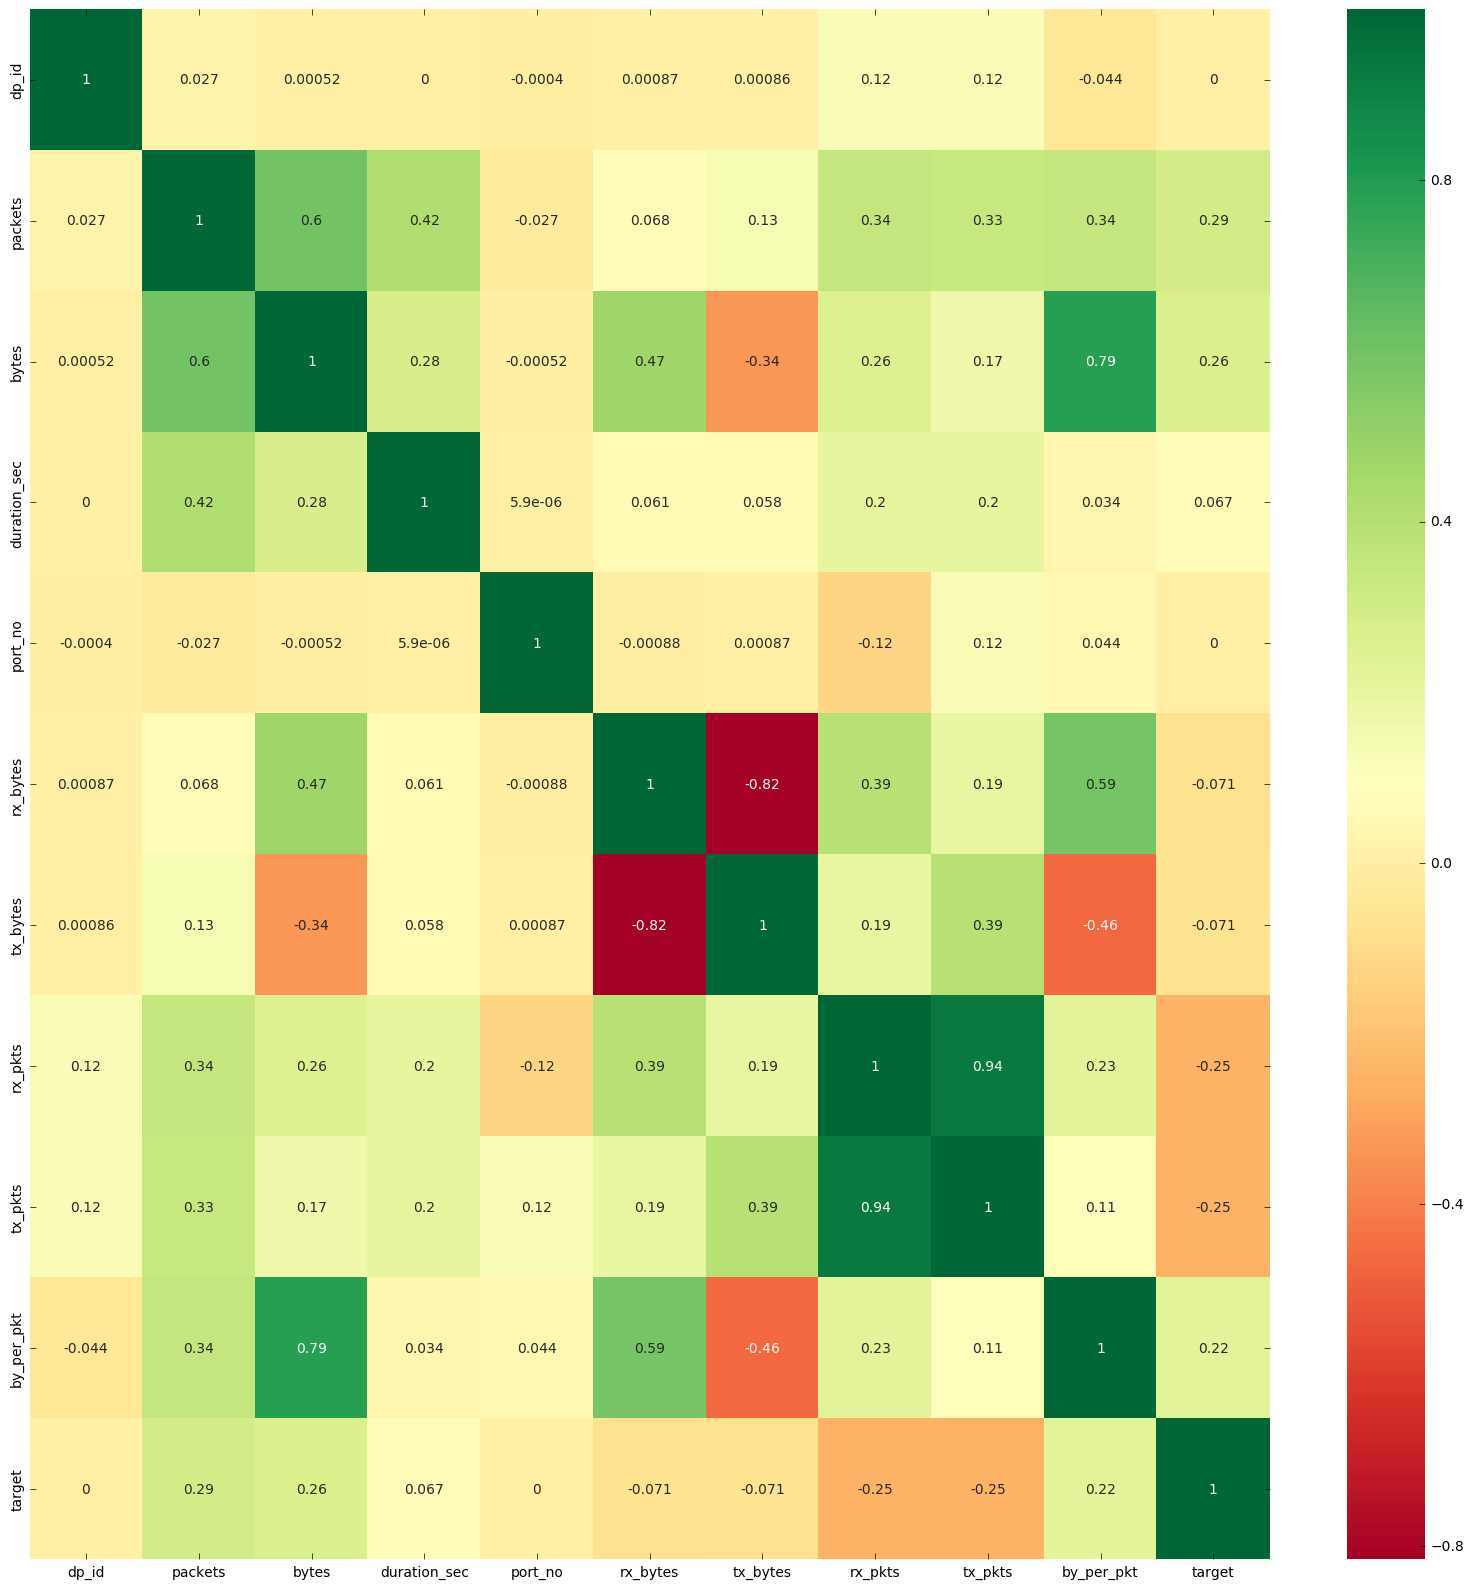

In [81]:
import seaborn as sns

#calculate the correlation and plot 
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

#### we select the feature with high corretion(abs larger than 0.2) with the target value

In [82]:
features = ["bytes","rx_pkts","tx_pkts","packets","by_per_pkt"]
x = df[features]
y = preprocessing.LabelEncoder().fit_transform(df["target"])
x[:3]

,bytes,rx_pkts,tx_pkts,packets,by_per_pkt
0,75716,1015986,1091698,491,154.207739
1,45745,1091714,1015960,341,134.149560
2,46020,1125116,1016005,343,134.169096


### feature scaling 

In [83]:
#min max scaling 
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x[features] = scaler.fit_transform(x[features])

/Users/zhaojiayi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/zhaojiayi/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# semi-supervised machine learning 

In [84]:
# x_train is the data set used to train the model including the labeled and unlabeled data
# x_testset is the labeled dataset used to evaluate the classifier in each iteration
# x_labeled is the labeled training data
# x_rest is the unlabeled training data

x_train,x_testset,y_train,y_testset = train_test_split(x, y, test_size=0.20, random_state=20)
X_labeled, X_rest, Y_labeled, Y_rest = train_test_split(x_train, y_train, test_size=0.9, random_state=20)

#iteration number
iteration = 6

#number of samples added to the training set
num_samples = int(X_rest.shape[0]/iteration)
num_samples

602

In [85]:
#we use two model and compare them
#naive bayes and svm
#train the models with the labeled data
nb_clf = GaussianNB()
nb_clf.fit(X_labeled,Y_labeled)

svm_clf = svm.SVC()
svm_clf.fit(X_labeled,Y_labeled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [86]:
#use the labeled data to train the classifier
x_train = X_labeled
y_train = Y_labeled

#store the classifiers to a list
naive_bayes_model = [nb_clf]
svm_model = [svm_clf]

nb_score = []
svm_score = []

print("iteration:",0, "naive bayes",nb_clf.score(x_testset,y_testset))
nb_score.append(nb_clf.score(x_testset,y_testset))
print("iteration:",0, "svm",svm_clf.score(x_testset,y_testset))
svm_score.append(svm_clf.score(x_testset,y_testset))
    
for i in range(0,iteration):
    start = (i) * num_samples
    end = (i+1) * num_samples - 1
#     print(start,end)
    
    
    #test the classifier on the unlabeled data
    x_test = X_rest[start:end]
    
    # use the predicted data as the new labels
    y_pred = nb_clf.predict(x_test)
    
    # append the data to the training set
    x_train = pd.concat([x_train,X_rest[start:end]])
    y_train = np.append(y_train,y_pred)
    
    #retrain the model
    nb_clf = GaussianNB()
    nb_clf.fit(x_train,y_train)
    svm_clf = svm.SVC()
    svm_clf.fit(x_train,y_train)
    
    #store the new classifier to the list
    naive_bayes_model.append(nb_clf)
    svm_model.append(svm_clf)
    
    #test the current classifier on the test set and report the score
    print("iteration:",i + 1, "naive bayes",nb_clf.score(x_testset,y_testset))
    nb_score.append(nb_clf.score(x_testset,y_testset))
    print("iteration:",i + 1, "svm",svm_clf.score(x_testset,y_testset))
    svm_score.append(svm_clf.score(x_testset,y_testset))

iteration: 0 naive bayes 0.9183266932270916
iteration: 0 svm 0.6135458167330677
iteration: 1 naive bayes 0.8645418326693227
iteration: 1 svm 0.7350597609561753
iteration: 2 naive bayes 0.8555776892430279
iteration: 2 svm 0.7420318725099602
iteration: 3 naive bayes 0.8545816733067729
iteration: 3 svm 0.7460159362549801
iteration: 4 naive bayes 0.851593625498008
iteration: 4 svm 0.749003984063745
iteration: 5 naive bayes 0.851593625498008
iteration: 5 svm 0.75
iteration: 6 naive bayes 0.8545816733067729
iteration: 6 svm 0.7460159362549801


#### save the classifier

In [87]:
# from sklearn.externals import joblib
# joblib.dump(svm_model[6],'semi_svm_app.pkl',compress=9)
# joblib.dump(naive_bayes_model[6],'semi_nb_app.pkl',compress=9)

#### plot the accuracy with the number of iterations

In [88]:
axis_x = [0,1,2,3,4,5,6]
plt.scatter(axis_x, svm_score, c='r', label='svm')
plt.scatter(axis_x, nb_score,label='naive bayes')
plt.ylim(0.4, 1)
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.title('semi-supervised classfication on applications')
plt.legend()

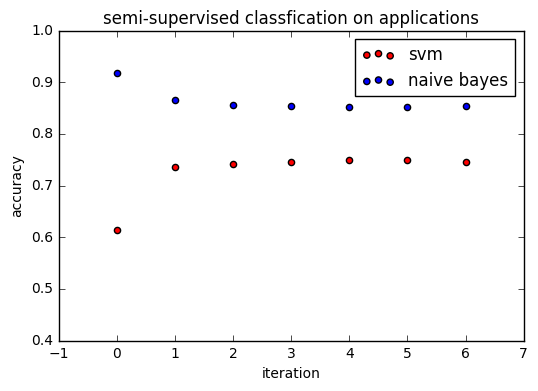

In [89]:
plt.show()